<a href="https://colab.research.google.com/github/wheemin-2/25-1-ESAA/blob/main/0523_HW_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **전이 학습**

합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요함, 하지만 충분히 큰 데이터셋을 얻는 것은 현실적으로 어려움

-> 이를 해결한 것이 전이학습 !

전이학습이란?

: 이미지넷(ImageNet) 처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것을 의미함

이때 아주 큰 데이터셋을 사용하여 훈련된 모델을 "사전 훈련된 모델(네트워크)"라고 부름

> 결과적으로 비교적 적은 수의 데이터를 가지고도 우리가 원하는 과제를 해결할 수 있다!

![transfer learning](https://thebook.io/img/080289/200.jpg)

*전이 학습을 위한 방법*
1. 특성 추출
2. 미세 조정 기법



## **특성 추출 기법**

특성 추출(feature extractor)
- ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후, 마지막에 완전연결층 부분만 새로 만듦
- 즉, 학습할 때는 마지막 완전연결층(이미지의 카테고리를 결정하는 부분)만 학습하고 나머지 계층들은 학습되지 않도록 구성

**[특성 추출의 구성]**
1. 합성곱층 : 합성곱층 + 풀링층
2. 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류

**작동 원리**

: 사전 훈련된 네트워크의 합성곱층(가중치 고정)에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서 훈련시킴

![feature extraction](https://thebook.io/img/080289/201.jpg)

사용 가능한 이미지 분류 모델

: Xception, Inception V3, ResNet50, VGG19, MobileNet

In [1]:
!pip install opencv-python

In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms  # 데이터 전처리에 사용
import torchvision.models as models  # 다양한 파이토치 네트워크 사용 가능
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [8]:
# 1. 저장소 전체를 clone
!git clone https://github.com/gilbutITbook/080289.git

# 2. 작업 디렉토리를 해당 폴더로 이동
%cd 080289/chap05/data/catanddog/

# 3. 파일 목록 확인
!ls

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 27 (delta 3), pack-reused 2246 (from 1)
Receiving objects: 100% (2278/2278), 330.30 MiB | 28.49 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.
/content/080289/chap05/data/catanddog
test  train


In [9]:
# 이미지 데이터 전처리 방법 정의

data_path = '/content/080289/chap05/data/catanddog/train'

transform = transforms.Compose([transforms.Resize([256,256]),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


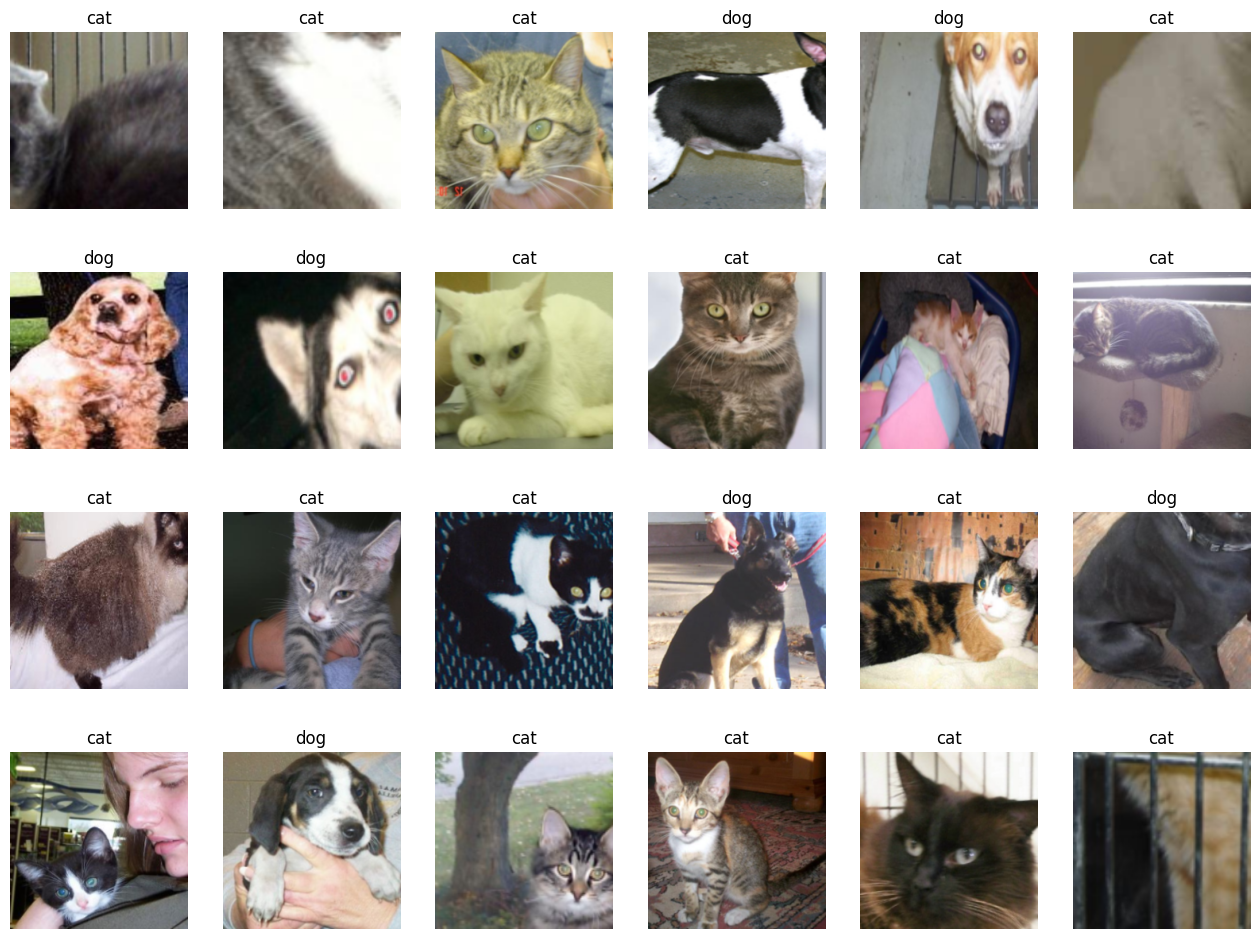

In [10]:
import numpy as np

samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

### 사전 훈련된 모델 내려받기

[ResNet18]

: 50개의 계층으로 구성된 합성곱 신경망, ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망으로 전이 학습에 사용되도록 사전 훈련된 모델을 제공하고 있음

입력 제약이 매우 크고, 충분한 메모리(RAM)가 없으면 학습 속도가 느릴 수 잇음

*무작위 가중치 모델 vs. 사전 학습된 모델의 가중치 사용*

*: pretrained=True 옵션 사용*


```
import torchvision.models as models
resnet18 = models.resnet18()  # 무작위의 가중치로 모델을 구성
resnet18 = models.resnet18(pretrained=True) # 사전 학습된 모델의 가중치 값 사용
```



In [7]:
# 사전 훈련된 ResNet18 모델 내려받기
# pretrained = True : 사전 학습된 가중치를 사용하겠다
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.0MB/s]


In [11]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)  # 파라미터 학습 X

### 완전연결층 추가

고양이와 개의 클래스를 분류하는 용도로 사용

![fully_conn_layer](https://thebook.io/img/080289/212.jpg)

In [12]:
resnet18.fc = nn.Linear(512,2)

In [13]:
# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0308, -0.0403,  0.0260,  ...,  0.0131,  0.0187,  0.0227],
        [ 0.0242,  0.0352,  0.0378,  ..., -0.0266,  0.0290,  0.0343]])
fc.bias tensor([-0.0225, -0.0426])


✅ 현재 상황 요약

기존 ResNet18 파라미터들
- `set_parameter_requires_grad(resnet18)` 호출로 인해 모든 기존 레이어 파라미터 (conv1, layer1, ..., avgpool 등) ➜ requires_grad = False

새롭게 생성한 Fully Connected Layer (resnet18.fc)

- `resnet18.fc = nn.Linear(512, 2)` 호출로 새 레이어가 처음부터 생성됨 > **기본 설정: requires_grad = True**

- 이 레이어에는 두 개의 파라미터가 자동 생성됨
    - fc.weight → shape: [2, 512]
    - fc.bias → shape: [2]

### 모델 객체 생성 및 손실 함수 정의

In [14]:
model = models.resnet18(pretrained=True)

# 모델의 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 완전연결층 변경 및 학습
model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 모델 학습

모델 학습을 위한 train_model 함수 생성

In [31]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()  # 현재 시각 저장
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()    #역전파 학습
            optimizer.step()

            # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)  # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc :
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        # 모델 재사용을 위해 저장
        torch.save(model.state_dict(), os.path.join('/content/080289/chap05/data/catanddog/','{0:0=2d}.path'.format(epoch)))
        print()

    time_elapsed = time.time() - since  # 실행 시간 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Acc: {:.4f}'.format(best_acc))

    # 모델의 정확도와 오차를 반환
    return acc_history, loss_history

In [32]:
# 모델에 추가된 완전연결층은 학습하도록 설정
# 학습을 통해 얻어지는 파라미터는 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad==True:
        params_to_update.append(param)
        print('\t', name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [33]:
# 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loss: 0.1809 Acc: 0.9169

Epoch 1/12
----------
Loss: 0.2236 Acc: 0.9013

Epoch 2/12
----------
Loss: 0.1771 Acc: 0.9247

Epoch 3/12
----------
Loss: 0.1703 Acc: 0.9221

Epoch 4/12
----------
Loss: 0.2137 Acc: 0.8883

Epoch 5/12
----------
Loss: 0.2117 Acc: 0.8961

Epoch 6/12
----------
Loss: 0.1754 Acc: 0.9221

Epoch 7/12
----------
Loss: 0.1833 Acc: 0.9221

Epoch 8/12
----------
Loss: 0.1852 Acc: 0.9221

Epoch 9/12
----------
Loss: 0.2061 Acc: 0.9091

Epoch 10/12
----------
Loss: 0.1738 Acc: 0.9195

Epoch 11/12
----------
Loss: 0.1421 Acc: 0.9532

Epoch 12/12
----------
Loss: 0.1587 Acc: 0.9403

Training complete in 10m 42s
Best Acc: 0.9532


### 테스트 데이터 예측

In [34]:
# 테스트 데이터 호출 및 전처리

test_path = '/content/080289/chap05/data/catanddog/test'

transform = transforms.Compose([transforms.Resize(224),
                                transforms.RandomResizedCrop(224),
                                transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)

print(len(test_dataset))

98


In [38]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/080289/chap05/data/catanddog/'+'*.path')
    saved_models.sort()   # 불러온 .pth 파일들 정렬
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():   # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        # 테스트 데이터의 정확도 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history


In [39]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/080289/chap05/data/catanddog/00.path', '/content/080289/chap05/data/catanddog/01.path', '/content/080289/chap05/data/catanddog/02.path', '/content/080289/chap05/data/catanddog/03.path', '/content/080289/chap05/data/catanddog/04.path', '/content/080289/chap05/data/catanddog/05.path', '/content/080289/chap05/data/catanddog/06.path', '/content/080289/chap05/data/catanddog/07.path', '/content/080289/chap05/data/catanddog/08.path', '/content/080289/chap05/data/catanddog/09.path', '/content/080289/chap05/data/catanddog/10.path', '/content/080289/chap05/data/catanddog/11.path', '/content/080289/chap05/data/catanddog/12.path']
Loading model /content/080289/chap05/data/catanddog/00.path
Acc: 0.8878

Loading model /content/080289/chap05/data/catanddog/01.path
Acc: 0.8571

Loading model /content/080289/chap05/data/catanddog/02.path
Acc: 0.8673

Loading model /content/080289/chap05/data/catanddog/03.path
Acc: 0.9082

Loading model /content/080289/chap05/data/catanddog/04.pat

### 모델 학습 결과 시각화

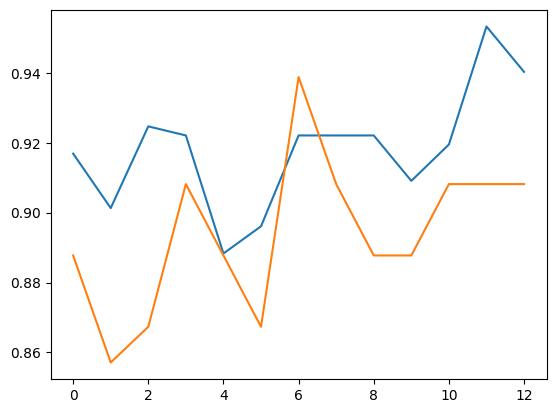

In [40]:
# epoch에 따른 정확도 시각화
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

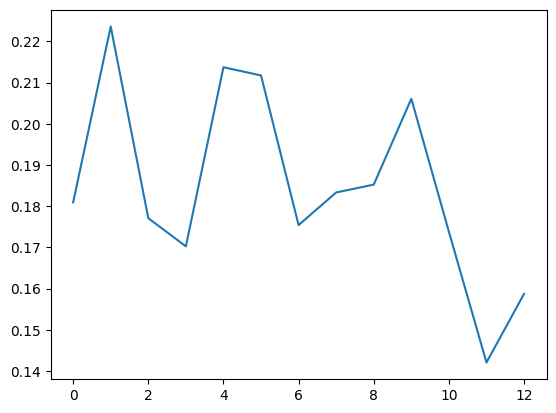

In [41]:
# 오차 그래프
plt.plot(train_loss_hist)
plt.show()

In [42]:
# 예측 이미지 출력
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image = image.clip(0, 1)
    return image

- `tensor.clone()` : 기존 텐서의 내용을 복사한 텐서를 생성하겠다는 의미
- `detach()` : 기존 텐서에서 기울기가 전파되지 않는 텐서
> `tensor.clone().detach()`는 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에 영향을 주지는 않겠다는 의미!

- `clip()` : 입력 값이 주어진 범위를 벗어날 때 입력 값을 특정 범위로 제한시키기 위해 사용
    - image.clip(0, 1) : image 데이터를 0과 1 사이의 값으로 제한하겠다는 의미

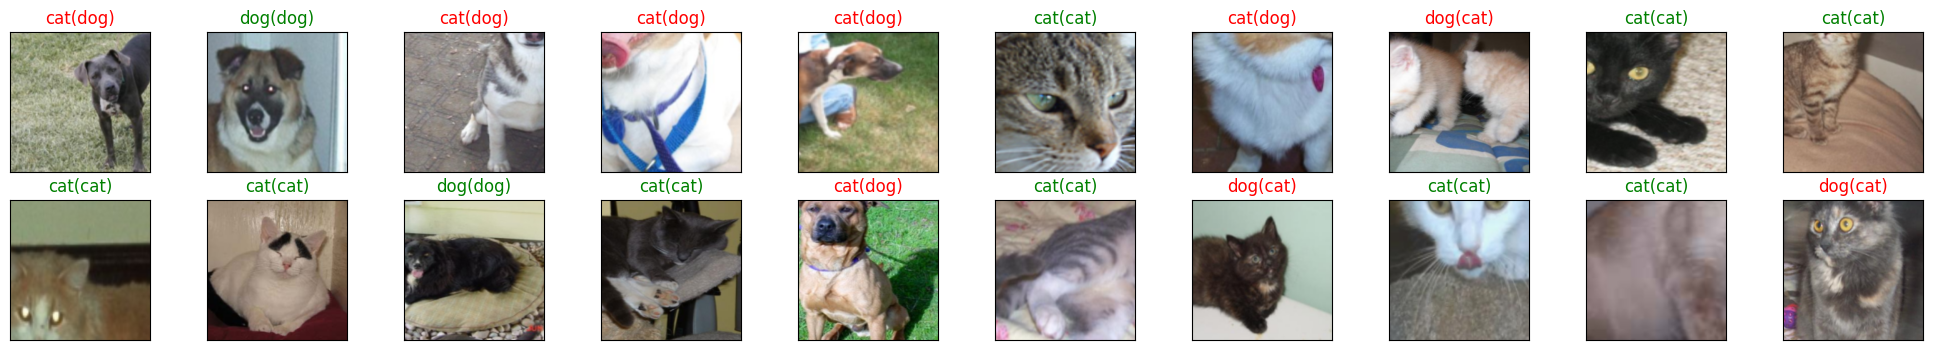

<Figure size 640x480 with 0 Axes>

In [44]:
# 고양이 / 개 예측 결과 출력
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## **미세 조정 기법**

미세 조정(fine-tuning) 기법

: 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식

- 특성 추출은 목표 특성을 잘 추출했다는 전제하에 좋은 성능을 낼 수 있음
- 특성이 잘못 추출되었다면(예를 들어 ImageNet 데이터셋의 이미지 특징과 전자상거래 물품의 이미지 특징이 다르다면) 미세 조정 기법으로 새로운 (전자상거래) 이미지 데이터를 사용하여 네트워크의 가중치를 업데이트해서 특성을 다시 추출할 수 있음
- 즉, 사전 학습된 모델을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습시키는 것!


**[데이터셋의 크기와 사전 훈련된 모델에 따른 미세 조정 기법 전략]**

1. 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우 : 모델 전체를 재학습
    - 데이터셋 크기가 크기 때문에 재학습시키는 것이 좋은 전략

2. 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우 : 합성곱층의 뒷부분(완전연결층과 가까운 부분)과 데이터 분류기를 학습시킴
    - 데이터셋이 유사하기 때문에 전체를 학습시키는 것보다는 강한 특징이 나타나는 합성곱층의 뒷부분과 데이터 분류기만 새로 학습하더라도 최적의 성능을 낼 수 있음

3. 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우 : 합성곱층의 일부분과 데이터 분류기를 학습시킴
    - 데이터가 적기 때문에 일부 계층에 미세 조정 기법을 적용한다고 해도 효과가 없을 수 있으므로 합성곱층 중 어디까지 새로 학습시켜야 할지 적당히 설정해 줄 필요가 있음

4. 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우 : 데이터 분류기만 학습시킴.
    - 데이터가 적기 때문에 많은 계층에 미세 조정 기법을 적용하면 과적합이 발생할 수 있으므로 최종 데이터 분류기인 완전연결층에 대해서만 미세 조정 기법을 적용함